In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from collections import defaultdict
from pathlib import Path
from typing import Dict

plt.style.use("ggplot")

In [4]:
def sample_name(s: str) -> str:
    for sfx in ["_rep1", "_rep2", "-singleplex", "-multiplex"]:
        s = s.replace(sfx, "")
    return s

In [5]:
smear_df = pd.read_csv("../../docs/smear_results.csv", index_col="sample")
ont_df = pd.read_csv("../../docs/ont_samples.csv", index_col="sample")

In [6]:
ont_comp_df = pd.read_html("../../results/report/nanopore_composition.html")
assert len(ont_comp_df) == 1
ont_comp_df = ont_comp_df[0]
ont_comp_df.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in ont_comp_df.columns]
ont_comp_df["source"] = "sputum"
ont_comp_df["technology"] = "nanopore"
ont_comp_df["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in ont_comp_df["sample"]]
ont_comp_df["is_multiplex"] = [not pd.isna(ont_df.at[s, "barcode_kit"]) for s in  ont_comp_df["sample"]]
# ont_comp_df

In [7]:
illumina_df1 = pd.read_html("../../results/report/illumina_culture_composition.html")
assert len(illumina_df1) == 1
illumina_df1 = illumina_df1[0]
illumina_df1.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in illumina_df1.columns]
illumina_df1["source"] = "culture"
illumina_df1["technology"] = "illumina"
illumina_df1["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in illumina_df1["sample"]]
# illumina_df1

In [8]:
illumina_df2 = pd.read_html("../../results/report/illumina_sputum_composition.html")
assert len(illumina_df2) == 1
illumina_df2 = illumina_df2[0]
illumina_df2.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in illumina_df2.columns]
illumina_df2["source"] = "sputum"
illumina_df2["technology"] = "illumina"
illumina_df2["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in illumina_df2["sample"]]
# illumina_df2

In [9]:
comp_df = pd.concat([ont_comp_df, illumina_df1, illumina_df2])
comp_df.reset_index(inplace=True)
# remove replicates
comp_df = comp_df.loc[~comp_df["sample"].str.contains("_rep")]
comp_df["sample"] = [s.split("-s")[0].split("-m")[0] for s in comp_df["sample"]]
comp_df["is_multiplex"].fillna(False, inplace=True)
comp_df

,index,sample,keep,keep%,contam,contam%,unmapped,unmapped%,total,coverage,lineage,species,source,technology,smear,is_multiplex
0,0,P201,895,0.11%,644877,77.08%,190847,22.81%,836619,0.2,4.10,Mycobacterium_tuberculosis,sputum,nanopore,+,True
1,1,P202,24865,1.83%,1153816,85.11%,176981,13.05%,1355662,6.0,1.1.2,Mycobacterium_tuberculosis,sputum,nanopore,+,True
2,2,P203,3768,0.46%,783301,95.23%,35497,4.32%,822566,1.1,4.10,Mycobacterium_tuberculosis,sputum,nanopore,+,True
3,3,P203,19938,0.45%,4257677,96.47%,136039,3.08%,4413654,6.6,4.1.2,Mycobacterium_tuberculosis,sputum,nanopore,+,False
4,4,P204,414,0.07%,57693,10.05%,515903,89.88%,574010,0.1,4.10,Unknown,sputum,nanopore,+,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,85,Test_NC2,7555,0.37%,1977115,96.53%,63620,3.11%,2048290,0.5,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False
231,86,Test_NC3,22874,1.04%,2080051,94.85%,89957,4.10%,2192882,1.5,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False
232,87,Test_NC4,14074,1.00%,1316174,93.65%,75229,5.35%,1405477,0.9,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False
233,88,Test_NC5,28061,1.61%,1554571,88.97%,164633,9.42%,1747265,1.9,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False


Firstly, let's take a look at how many of the Nanopore-sequenced samples were sequenced on Illumina (sputum and culture)

In [10]:
ont_samples = {sample_name(s) for s in comp_df.query("technology=='nanopore'")["sample"]}
print(f"{len(ont_samples)} Nanopore sputum samples")

72 Nanopore sputum samples


In [11]:
culture_samples = {sample_name(s) for s in comp_df.query("technology=='illumina' and source=='culture'")["sample"]}
print(f"{len(culture_samples)} Illumina cultured samples")

52 Illumina cultured samples


In [12]:
sputum_samples = {sample_name(s) for s in comp_df.query("technology=='illumina' and source=='sputum'")["sample"]}
print(f"{len(sputum_samples)} Illumina sputum samples")

71 Illumina sputum samples


In [13]:
print(f"Samples sequenced on Nanopore but no Illumina sputum data: {ont_samples - sputum_samples}")

Samples sequenced on Nanopore but no Illumina sputum data: {'P226'}


This sample, `P226`, did have its sputum sequenced on Illumina according to the spreadsheet, but when Martin retrieved the data from the Oxford servers, he could not find it anywhere. Here is the information I have for its Illumina sputum sequencing:

| Id Sample  | Source | Date extraction | guid                                 | Reference Genome | Plate name          | Row ID | Column ID |
|------------|--------|-----------------|--------------------------------------|------------------|---------------------|--------|-----------|
| Mada-P226S | Sputum | 21/8/19         | fad80bbf-50e2-403f-beed-d40fafc5202f | R00000039        | PR2832_CRyPTIC_Peru | E      | 6         |



In [14]:
print(f"Samples sequenced on Nanopore but no Illumina culture data:\n {sorted(ont_samples - culture_samples)}")

Samples sequenced on Nanopore but no Illumina culture data:
 ['P201', 'P206', 'P207', 'P208', 'P213', 'P219', 'P220', 'PCtrl-1', 'PCtrl-2', 'PCtrl-3', 'PCtrl-4', 'PCtrl-5', 'PCtrl-6', 'Test_18', 'Test_NC1', 'Test_NC2', 'Test_NC3', 'Test_NC4', 'Test_NC5', 'Test_NC6']


In [15]:
samples_in_all = ont_samples & culture_samples & sputum_samples

In [16]:
print(f"There are {len(samples_in_all)} samples with data for all three conditions")

There are 51 samples with data for all three conditions


## Negative controls
According to the study protocol, each site collected 6 negative controls - smear microscopy negative and MTB/RIF Xpert negative.

Let's check if Nanopore got the species correct for these - i.e., didn't call Mtb

In [17]:
comp_df.loc[comp_df["sample"].map(lambda r: "NC" in r or "PC" in r)]

,index,sample,keep,keep%,contam,contam%,unmapped,unmapped%,total,coverage,lineage,species,source,technology,smear,is_multiplex
36,36,PCtrl-1,114,0.01%,755970,91.07%,73987,8.91%,830071,0.1,4.10,Unknown,sputum,nanopore,-,True
37,37,PCtrl-1,489,0.01%,4732561,93.11%,349673,6.88%,5082723,0.2,4.10,Unknown,sputum,nanopore,-,False
38,38,PCtrl-2,332,0.01%,2473969,83.15%,500914,16.84%,2975215,0.1,4.10,Unknown,sputum,nanopore,-,False
39,39,PCtrl-3,93,0.01%,711772,84.96%,125882,15.03%,837747,0.0,4.10,Unknown,sputum,nanopore,-,True
40,40,PCtrl-3,935,0.01%,10283833,87.18%,1511432,12.81%,11796200,0.3,4.10,Unknown,sputum,nanopore,-,False
41,41,PCtrl-4,67,0.01%,899563,92.26%,75354,7.73%,974984,0.0,4.10,Unknown,sputum,nanopore,-,False
42,42,PCtrl-5,106,0.03%,347714,88.80%,43737,11.17%,391557,0.1,4.10,Unknown,sputum,nanopore,-,True
43,43,PCtrl-5,99,0.01%,1084775,88.34%,143102,11.65%,1227976,0.1,4.10,Unknown,sputum,nanopore,-,False
44,44,PCtrl-6,557,0.00%,10961081,93.86%,716200,6.13%,11677838,0.1,4.10,Unknown,sputum,nanopore,-,False
81,81,Test_NC1,212,0.01%,1575927,92.75%,122899,7.23%,1699038,0.1,4.10,Unknown,sputum,nanopore,-,True


So all Nanopore negative controls have a species call (from Mykrobe) of "Unknown" with all having less than 1300 reads that map to the H37Rv reference genome.  
However, there are seven (1 Madagascar and all 6 Mumbai) Illumina sputum negative controls with an Mtb call. Most of these samples also have 1-2x coverage over the Mtb genome. However, there is considerable overlap in the MTBC genomes, so if the negative control patients had an MTBC infection, this could confound...

## Read depth (coverage)
The sequencing from culture returned at least 100x coverage for all samples (except one which had 85x).

Let's have a look at what sort of coverage we got from sputum for Nanopore and Illumina.

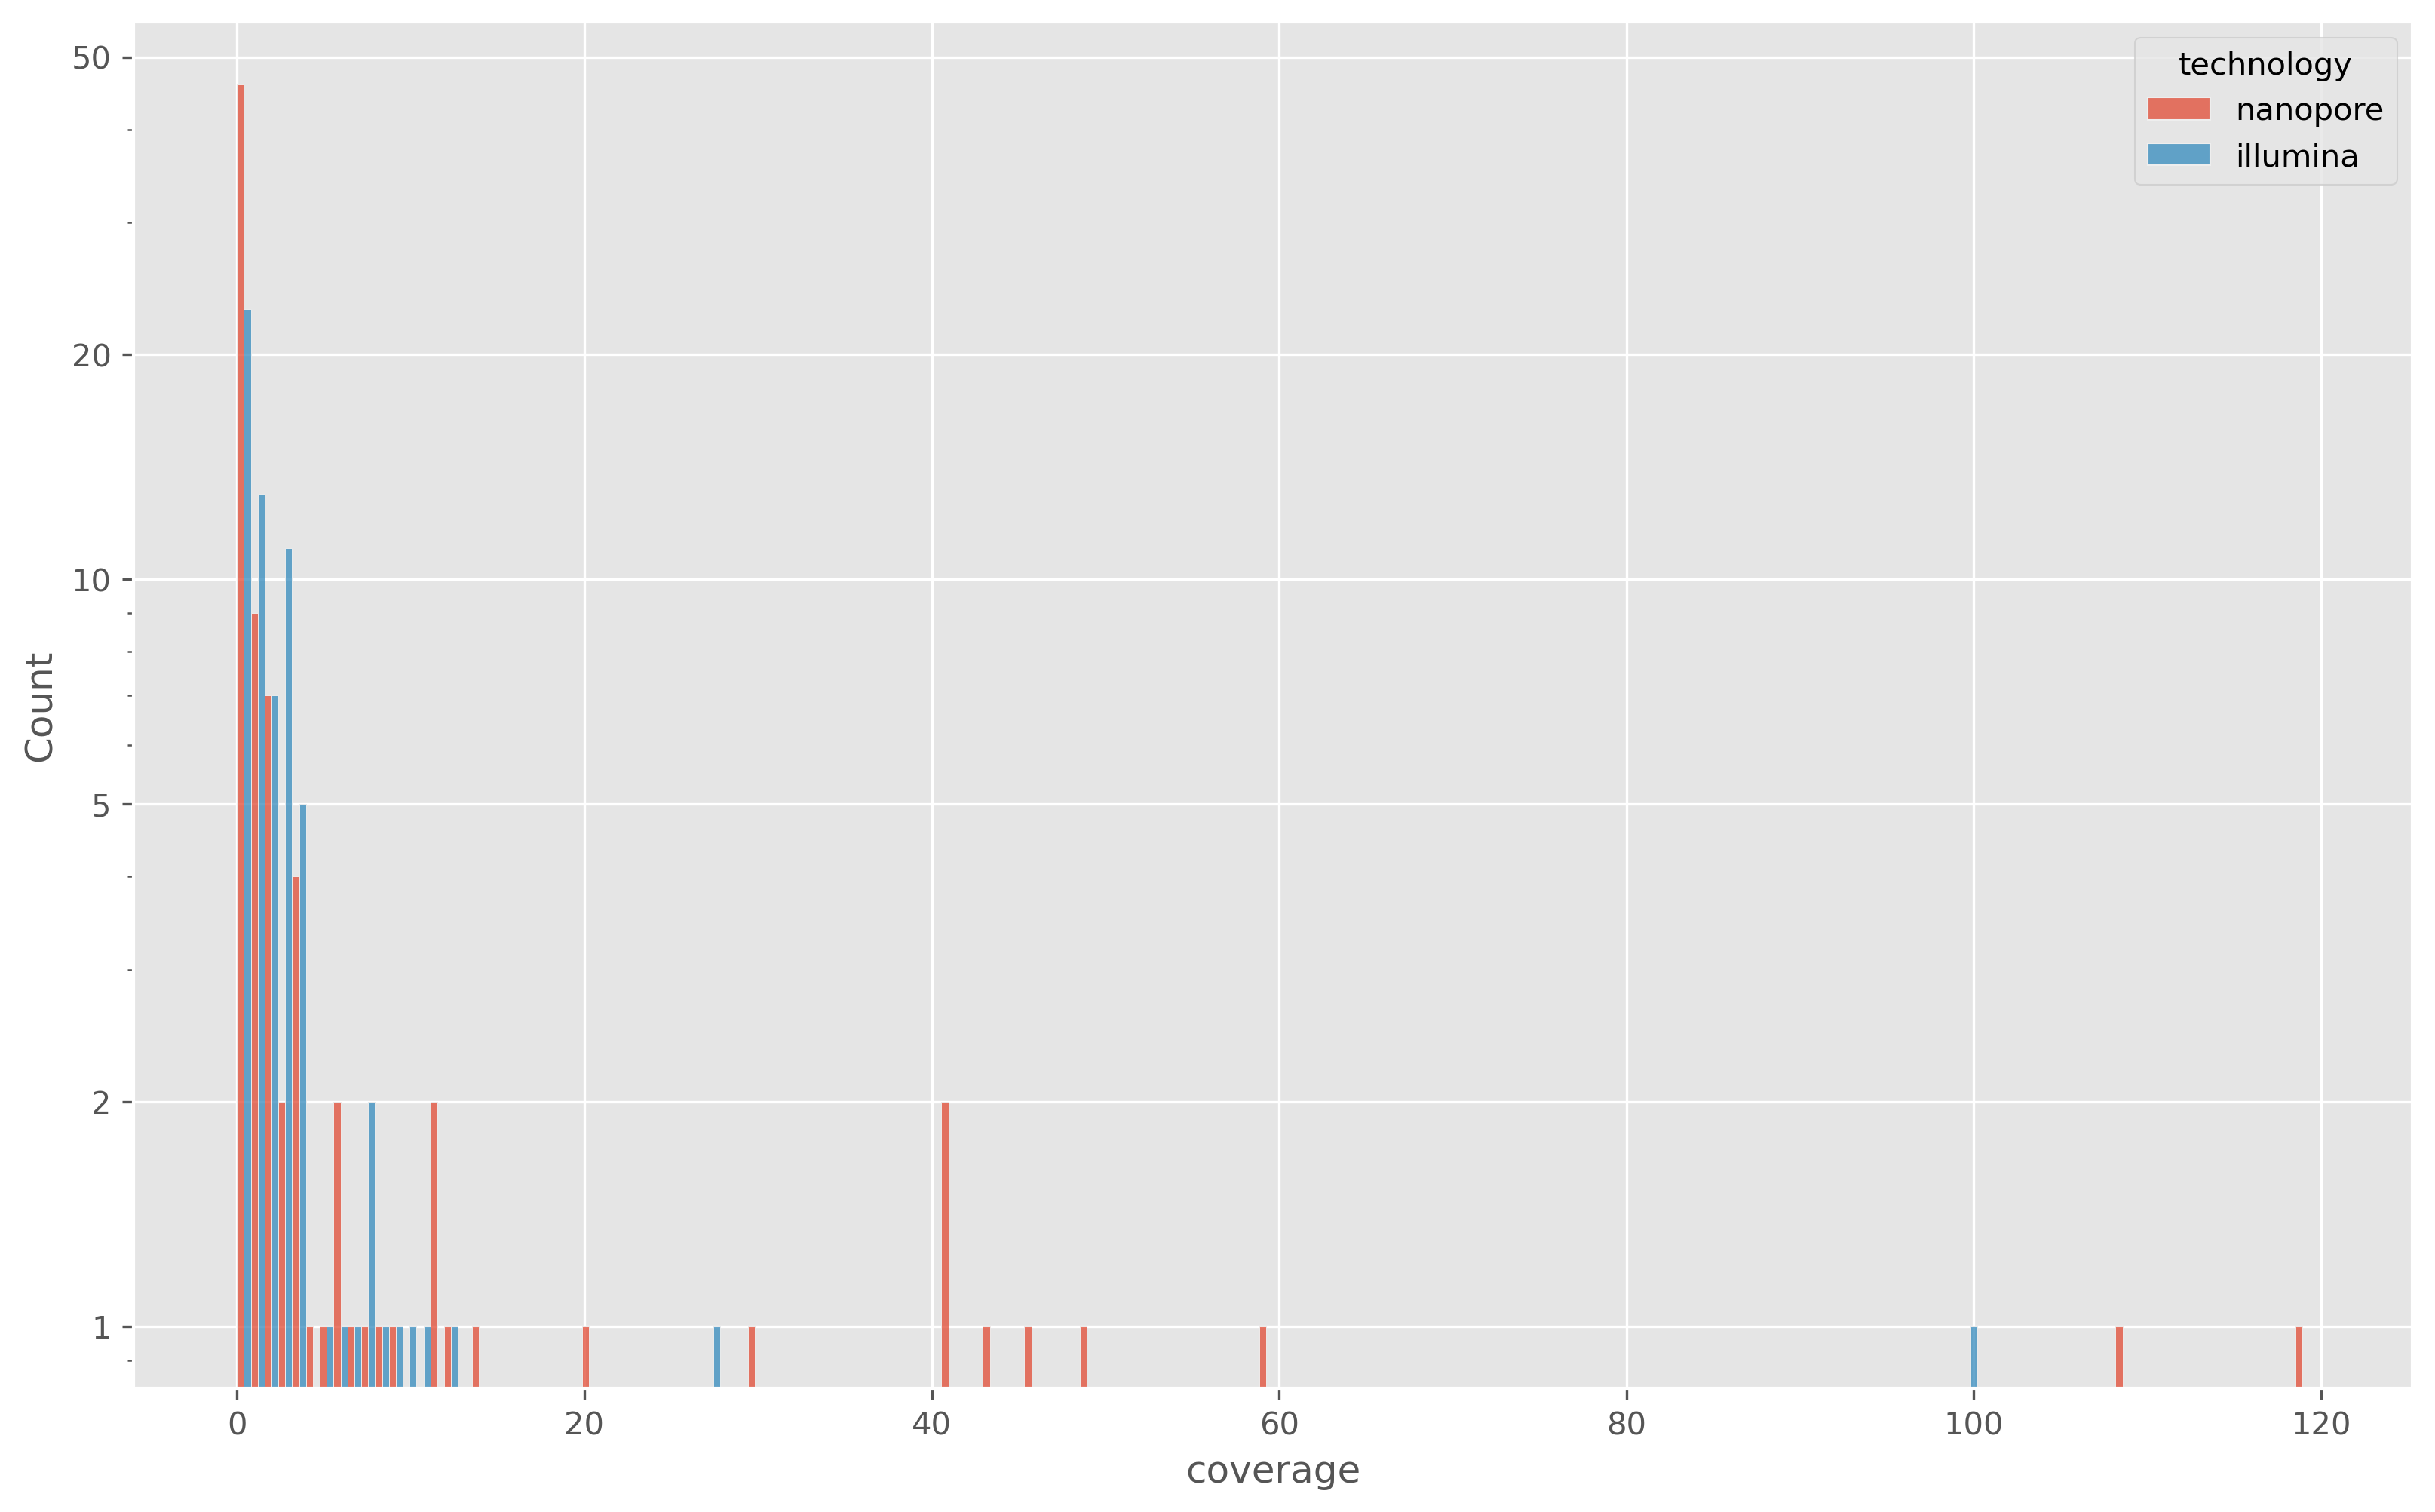

In [18]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
data = comp_df.query("source=='sputum'")
x = "coverage"
hue = "technology"
sns.histplot(data=data, x=x, hue=hue, ax=ax, multiple="dodge", bins=150)
ax.set_yscale("log")
ticks = [1, 2, 5, 10, 20, 50]
ax.set_yticks(ticks)
_ = ax.set_yticklabels(ticks)

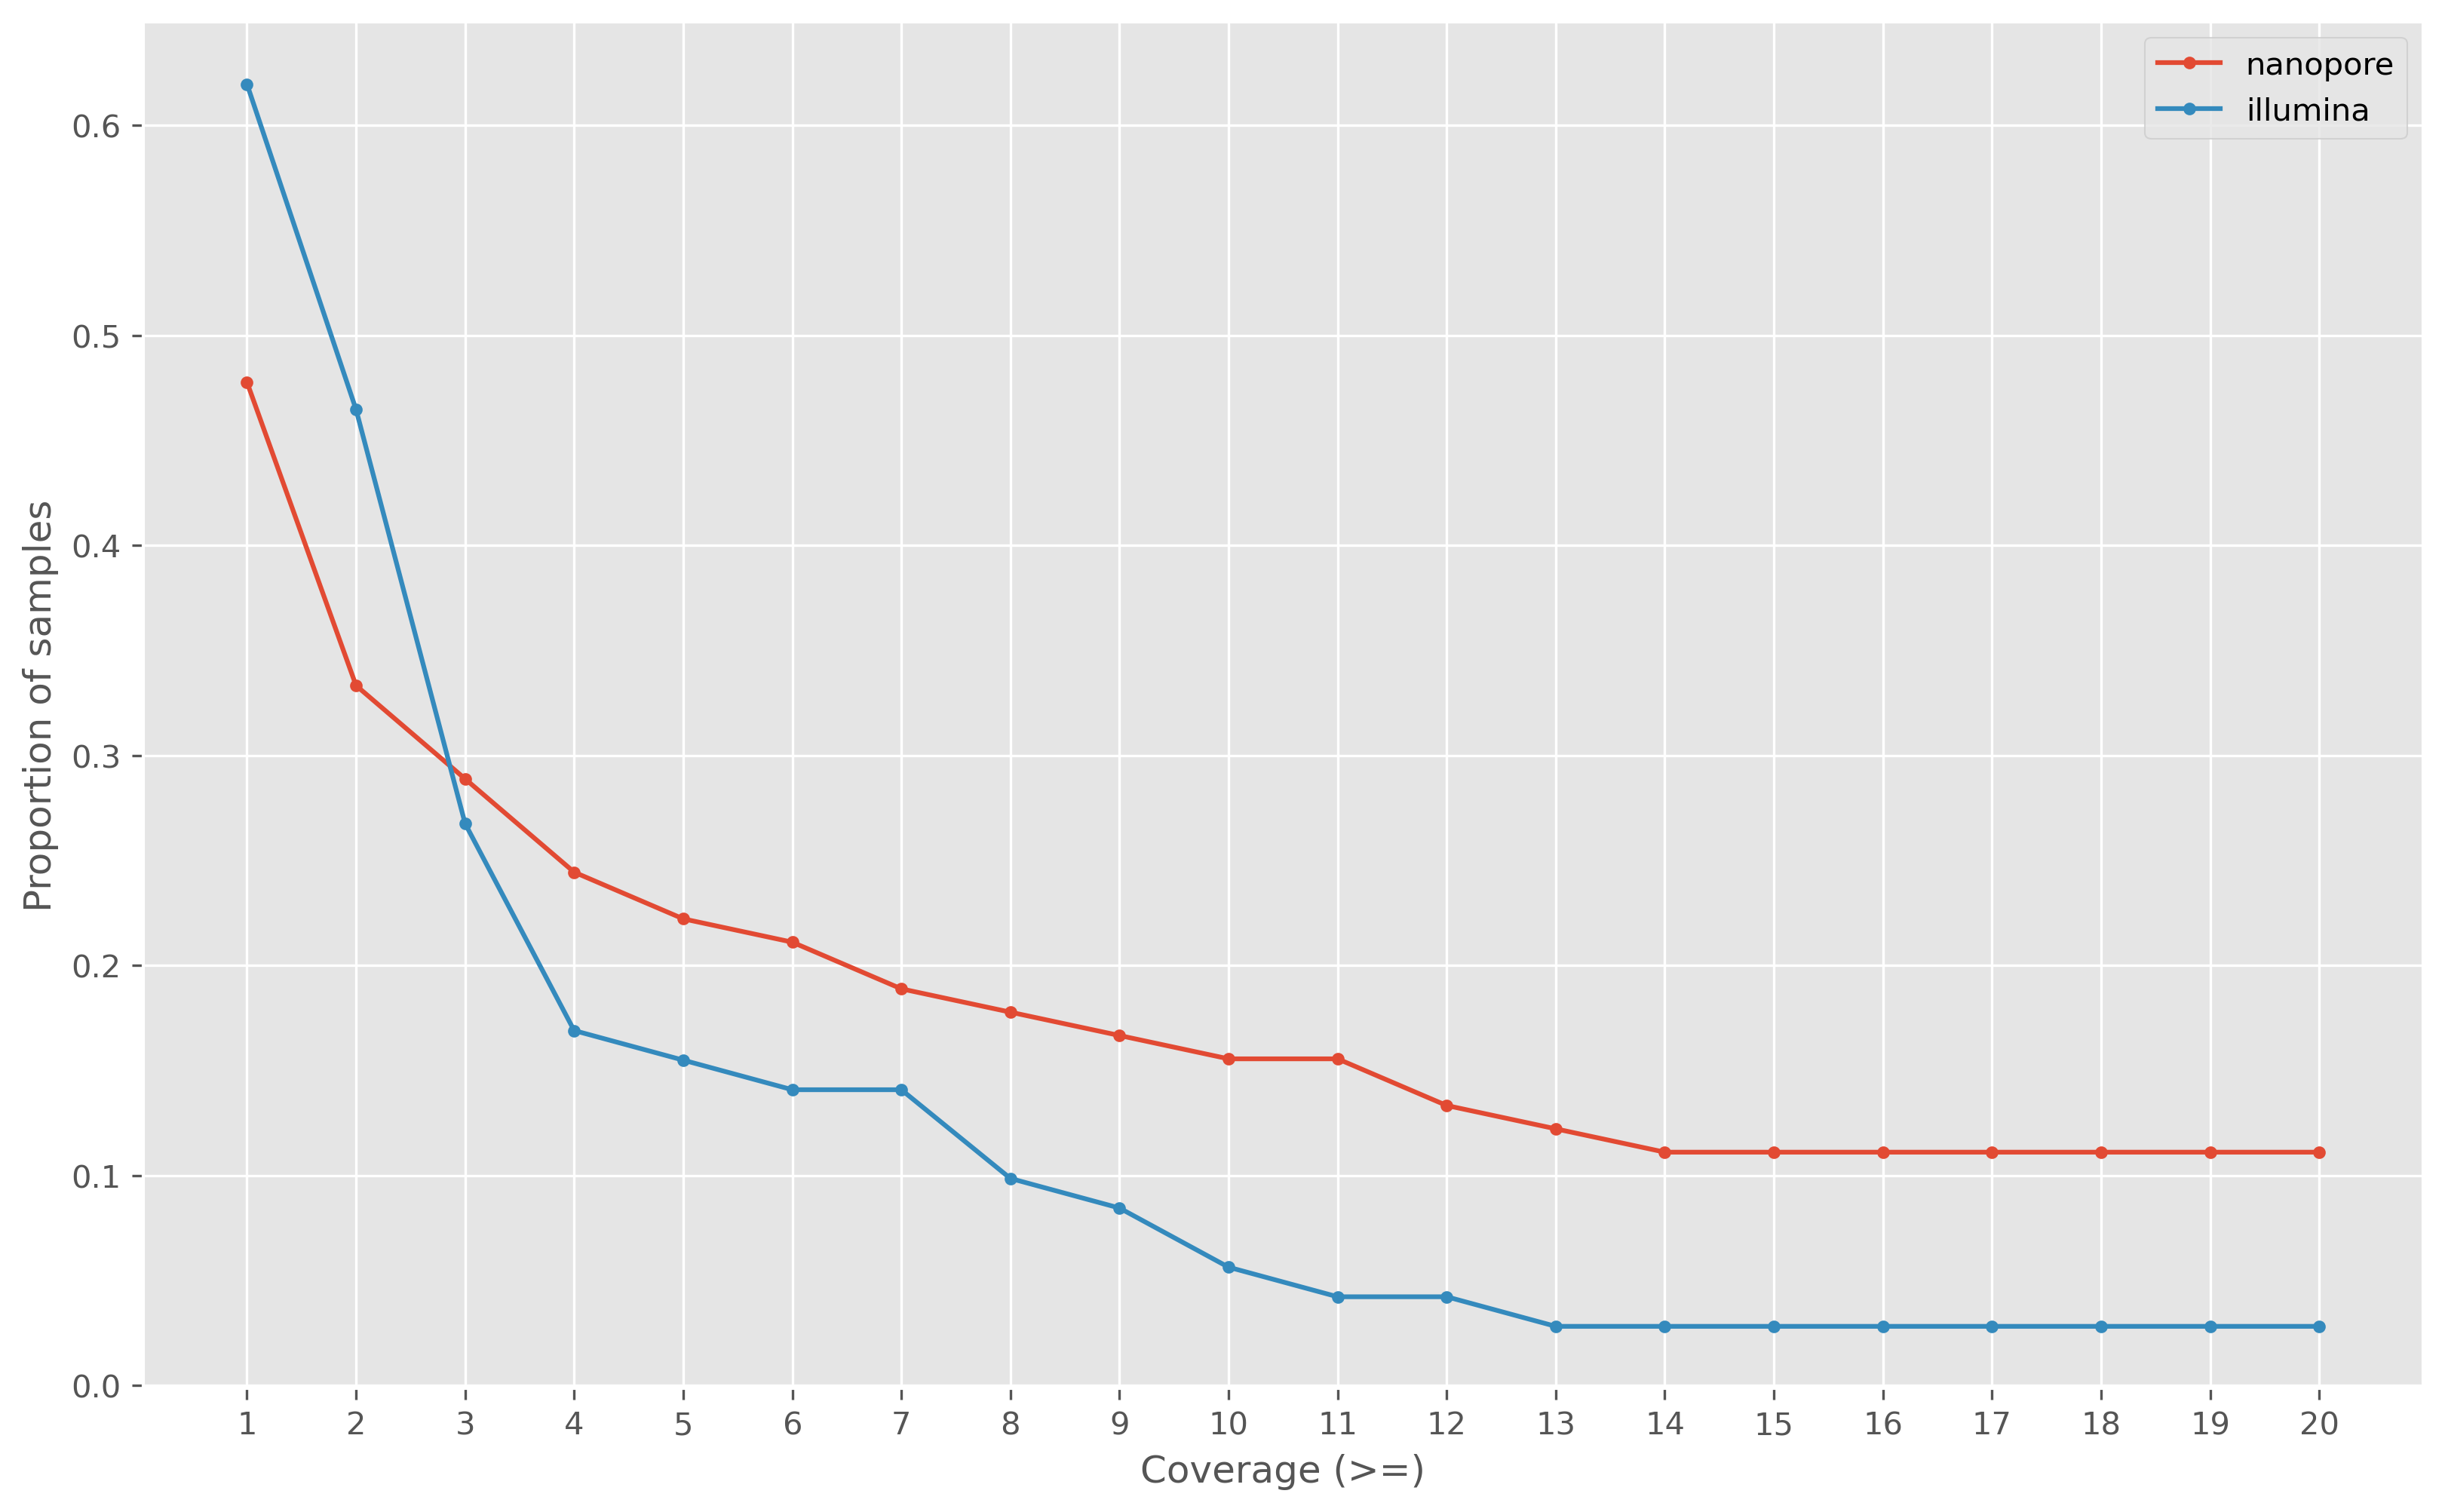

In [19]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ont_ys = []
ill_ys = []
for y in range(1, 21):
    d = data.query("coverage>=@y")
    q = "technology=='nanopore'"
    p = len(d.query(q)) / len(data.query(q))
    ont_ys.append(p)
    q = "technology=='illumina'"
    p = len(d.query(q)) / len(data.query(q))
    ill_ys.append(p)
    
ax.plot(range(1, 21), ont_ys, label="nanopore", marker=".")
ax.plot(range(1, 21), ill_ys, label="illumina", marker=".")
ax.legend()
ax.set(ylabel="Proportion of samples", xlabel="Coverage (>=)")
_ = ax.set_xticks(range(1, 21))

In [20]:
for y in range(2, 22, 2):
    d = data.query("coverage>=@y")
    q = "technology=='nanopore'"
    p = len(d.query(q)) / len(data.query(q))
    print(f"{p:.1%} ({len(d.query(q))}/{len(data.query(q))}) nanopore samples have coverage >= {y}")
    q = "technology=='illumina'"
    p = len(d.query(q)) / len(data.query(q))
    print(f"{p:.1%} ({len(d.query(q))}/{len(data.query(q))}) illumina samples have coverage >= {y}")

33.3% (30/90) nanopore samples have coverage >= 2
46.5% (33/71) illumina samples have coverage >= 2
24.4% (22/90) nanopore samples have coverage >= 4
16.9% (12/71) illumina samples have coverage >= 4
21.1% (19/90) nanopore samples have coverage >= 6
14.1% (10/71) illumina samples have coverage >= 6
17.8% (16/90) nanopore samples have coverage >= 8
9.9% (7/71) illumina samples have coverage >= 8
15.6% (14/90) nanopore samples have coverage >= 10
5.6% (4/71) illumina samples have coverage >= 10
13.3% (12/90) nanopore samples have coverage >= 12
4.2% (3/71) illumina samples have coverage >= 12
11.1% (10/90) nanopore samples have coverage >= 14
2.8% (2/71) illumina samples have coverage >= 14
11.1% (10/90) nanopore samples have coverage >= 16
2.8% (2/71) illumina samples have coverage >= 16
11.1% (10/90) nanopore samples have coverage >= 18
2.8% (2/71) illumina samples have coverage >= 18
11.1% (10/90) nanopore samples have coverage >= 20
2.8% (2/71) illumina samples have coverage >= 20


Let's look at read coverage by smear result

In [21]:
def legend_without_duplicate_labels(ax, title=""):
    handles, labels = ax.get_legend_handles_labels()
    labels = list(map(str.capitalize, labels))
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), title=title)

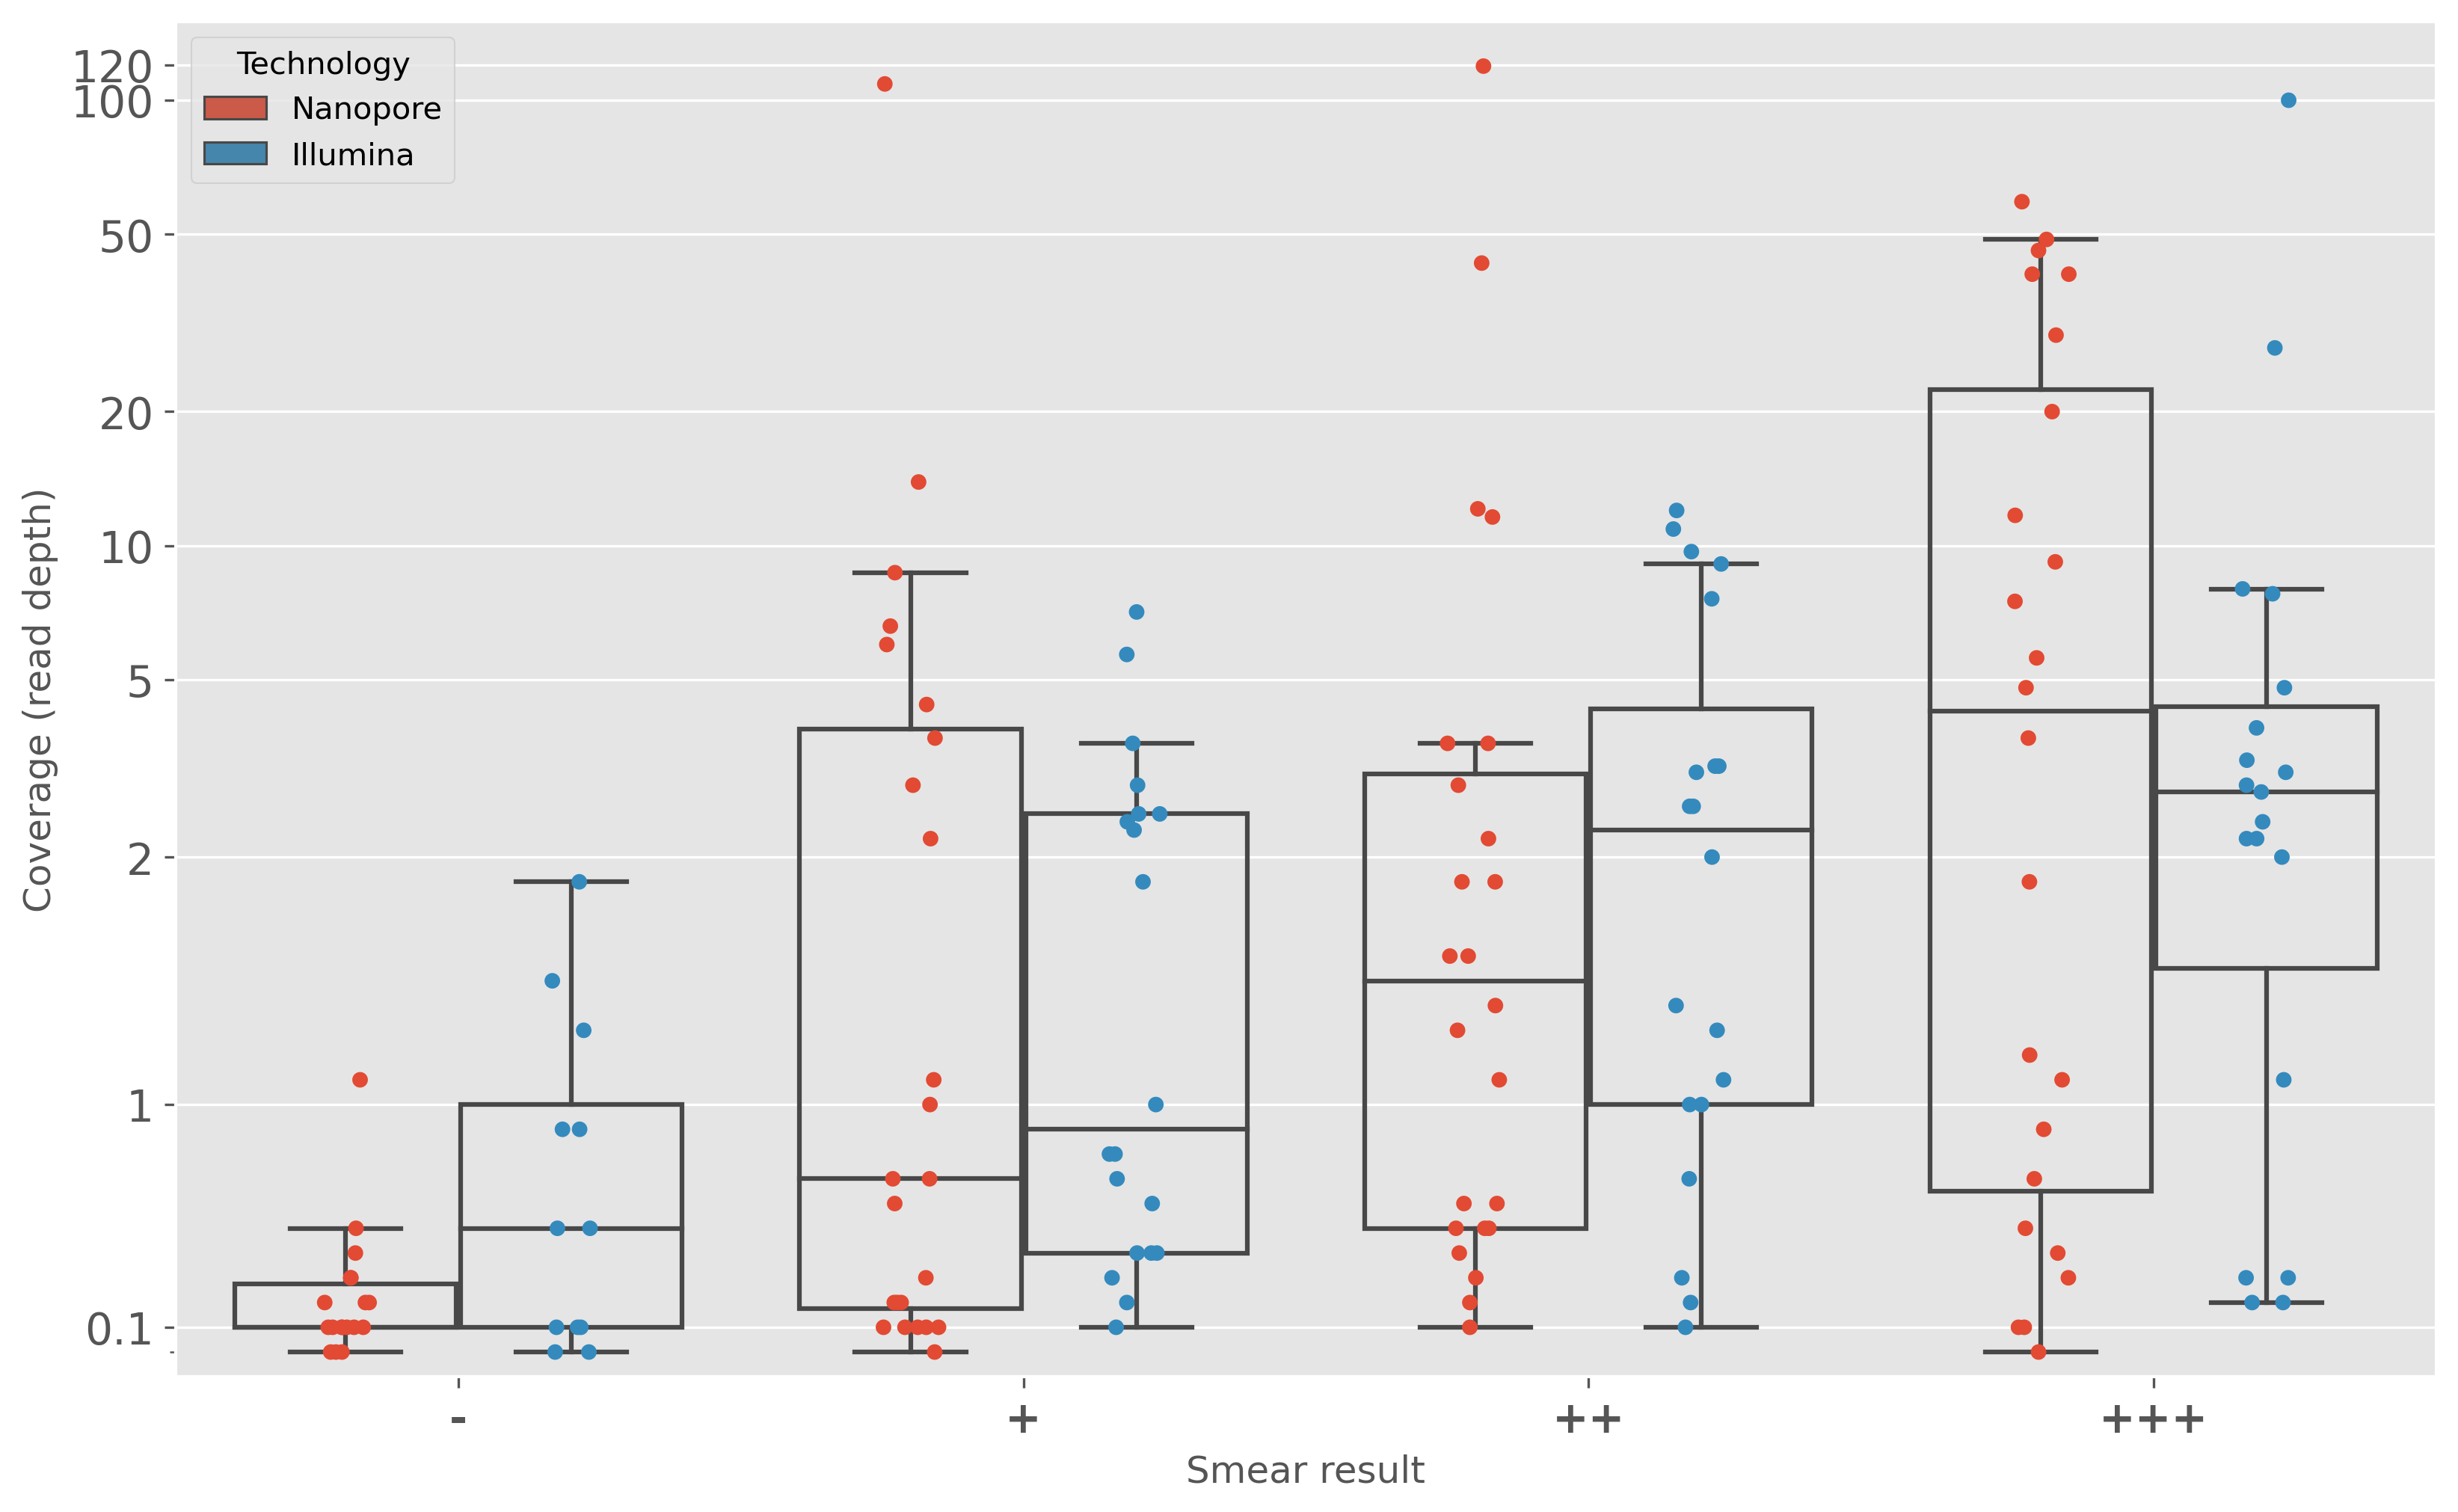

In [22]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
data = comp_df.query("source=='sputum'")
lsize = 14  # label size
x = "smear"
y = "coverage"
hue = "technology"
order = ["-", "+", "++", "+++"]
sns.boxplot(data=data, x=x, y=y, order=order, hue=hue, ax=ax, boxprops=dict(facecolor="none"), fliersize=0)
sns.stripplot(data=data, x=x, y=y, hue=hue, order=order, ax=ax, dodge=True)
ax.set_yscale("symlog")
ticks = [0.1, 1, 2, 5, 10, 20, 50, 100, 120]
ax.set_yticks(ticks)
_ = ax.set_yticklabels(ticks)
ax.set_xlabel("Smear result")
legend_without_duplicate_labels(ax, "Technology")
ax.set_ylim((-0.1, 150))
_ = ax.set_ylabel("Coverage (read depth)")
for label in (ax.get_xticklabels() + ax.get_xticklabels()):
    label.set_fontsize(lsize)
    label.set_fontweight('bold')
ax.yaxis.set_tick_params(labelsize=lsize)

Load the krona composition data

In [23]:
def load_krona_counts(path: Path) -> Dict[str, int]:
    counter = defaultdict(int)
    with open(path) as fp:
        for row in map(str.rstrip, fp):
            count, organism = row.split("\t")[:2]
            counter[organism] += int(count)
    total_reads = sum(counter.values())
    for k, v in counter.items():
        counter[k] = v/total_reads
    return counter

In [24]:
tsvs = list(Path("../../results/").rglob("*.krona.tsv"))

In [25]:
counts = dict()
for p in tsvs:
    tech = p.parts[3]
    if tech == "illumina":
        source = p.parts[-2]
    else:
        source = "sputum"
    name = p.name.split(".")[0]
    counts[(tech, source, name)] = load_krona_counts(p)

In [26]:
counts

{('illumina', 'sputum', 'Test_19'): defaultdict(int,
             {'NTM': 0.05690190288713911,
              'Unmapped': 0.1354957349081365,
              'Virus': 6.233595800524934e-06,
              'Bacteria': 0.6017339238845144,
              'TB': 0.0738507217847769,
              'Human': 0.13201148293963255}),
 ('illumina', 'sputum', 'Test_56'): defaultdict(int,
             {'NTM': 0.0007553644548045964,
              'Unmapped': 0.0490321712166442,
              'Virus': 1.3145918113550233e-07,
              'Bacteria': 0.07614602170338497,
              'TB': 0.009214105464968494,
              'Human': 0.8648522057010166}),
 ('illumina', 'sputum', 'P213'): defaultdict(int,
             {'NTM': 0.02293827505347731,
              'Unmapped': 0.23870360705385957,
              'Virus': 4.410499930167084e-05,
              'Bacteria': 0.18764104411235014,
              'TB': 0.01872992303677622,
              'Human': 0.5319430457442351}),
 ('illumina', 'sputum', 'P207'): defaul

In [27]:
comp_stack = pd.DataFrame(counts).T.reset_index().rename(columns={"level_0": "technology", "level_1": "source", "level_2": "name"}).fillna(0).melt(
    value_vars=["NTM", "Unmapped", "Virus", "Bacteria", "TB", "Human"], 
    id_vars=["technology", "name", "source"],
    var_name="Organism",
    value_name="num_reads"
)

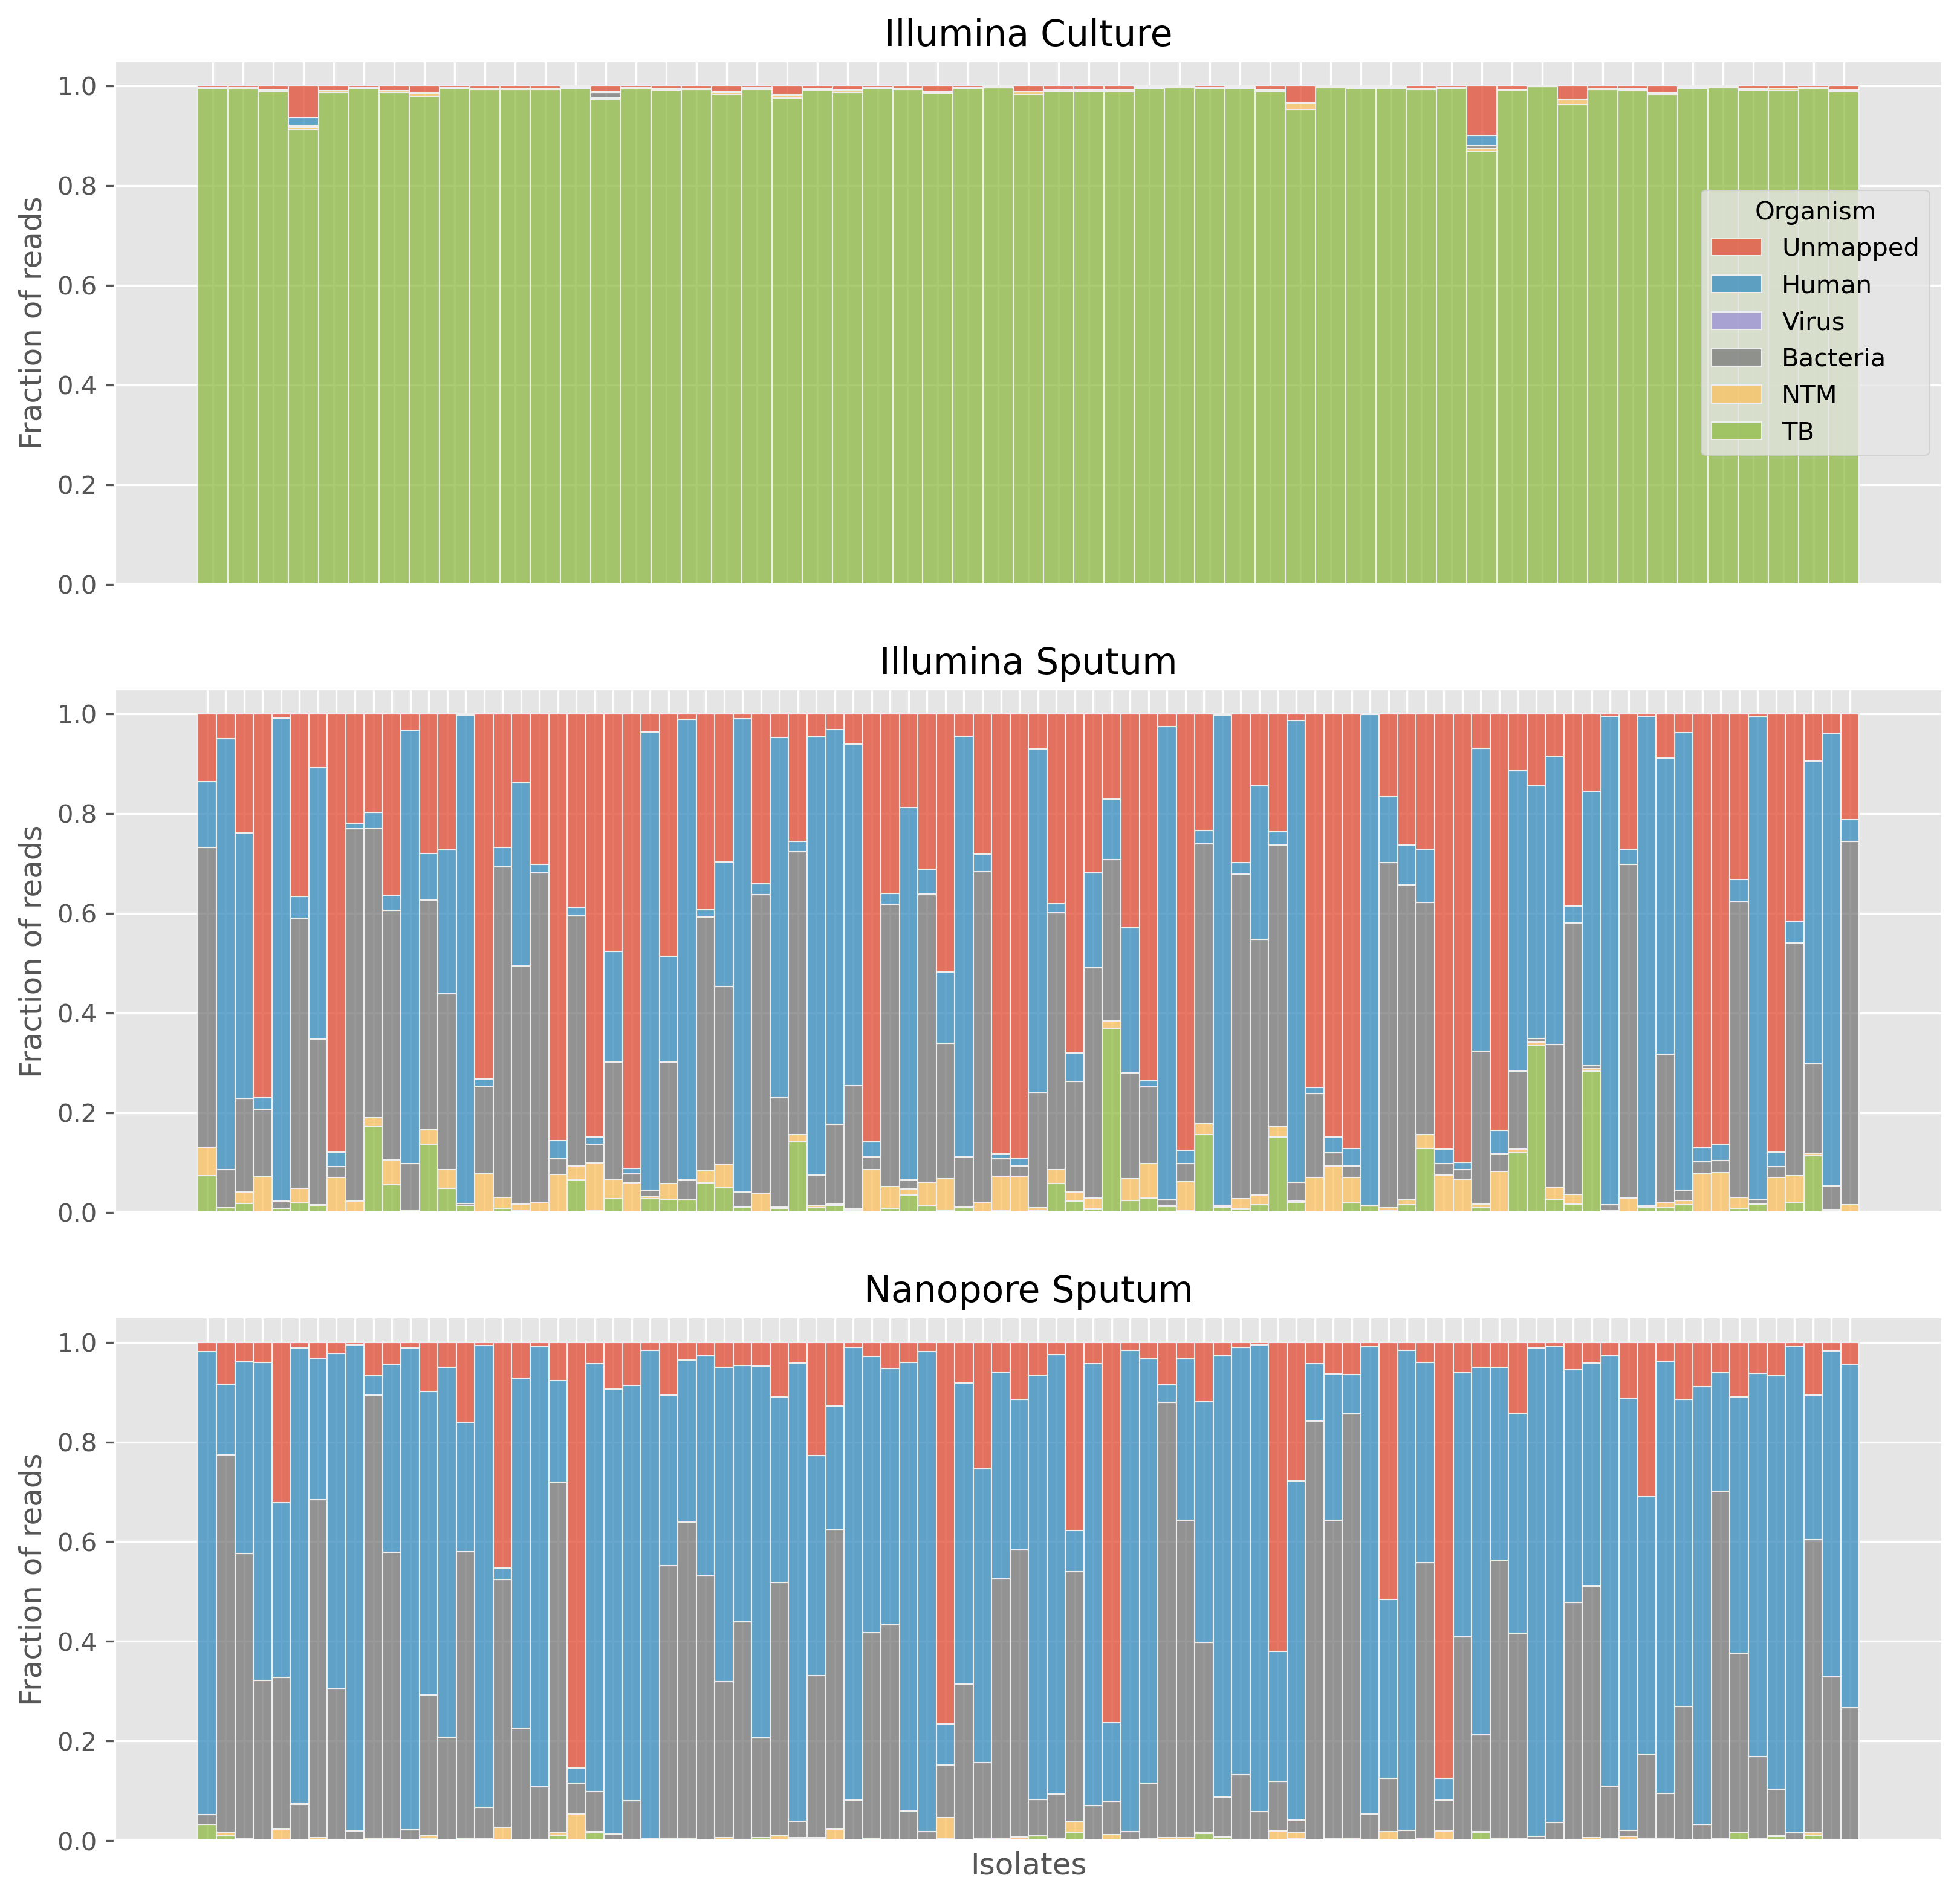

In [28]:
cats = [("illumina", "culture"), ("illumina", "sputum"), ("nanopore", "sputum")]
fig, axes = plt.subplots(figsize=(13, 13), dpi=300, nrows=len(cats))

for (tech, src), ax in zip(cats, axes.flatten()):
    data = comp_stack.query("technology==@tech and source==@src")

    ax = sns.histplot(
        data=data,
        x='name',
        # Use the value variable here to turn histogram counts into weighted
        # values.
        weights='num_reads',
        hue='Organism',
        multiple='stack',
    #     palette=['#24b1d1', '#ae24d1'],
        # Add white borders to the bars.
    #     edgecolor='white',
        # Shrink the bars a bit so they don't touch.
    #     shrink=0.8,
    #     stat="percent",
    #     common_norm=False
        hue_order=reversed(["TB", "NTM", "Bacteria", "Virus", "Human", "Unmapped"]),
        ax=ax
    )
    xlabel = "Isolates" if tech == "nanopore" else None
    ax.set(title=f"{tech.capitalize()} {src.capitalize()}", xlabel=xlabel, ylabel="Fraction of reads")
    if not src == "culture":
        ax.get_legend().remove()
    else:
        sns.move_legend(ax, "center right")

    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

Let's look at how coverage changes when multiplexed

In [29]:
comp_df

,index,sample,keep,keep%,contam,contam%,unmapped,unmapped%,total,coverage,lineage,species,source,technology,smear,is_multiplex
0,0,P201,895,0.11%,644877,77.08%,190847,22.81%,836619,0.2,4.10,Mycobacterium_tuberculosis,sputum,nanopore,+,True
1,1,P202,24865,1.83%,1153816,85.11%,176981,13.05%,1355662,6.0,1.1.2,Mycobacterium_tuberculosis,sputum,nanopore,+,True
2,2,P203,3768,0.46%,783301,95.23%,35497,4.32%,822566,1.1,4.10,Mycobacterium_tuberculosis,sputum,nanopore,+,True
3,3,P203,19938,0.45%,4257677,96.47%,136039,3.08%,4413654,6.6,4.1.2,Mycobacterium_tuberculosis,sputum,nanopore,+,False
4,4,P204,414,0.07%,57693,10.05%,515903,89.88%,574010,0.1,4.10,Unknown,sputum,nanopore,+,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,85,Test_NC2,7555,0.37%,1977115,96.53%,63620,3.11%,2048290,0.5,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False
231,86,Test_NC3,22874,1.04%,2080051,94.85%,89957,4.10%,2192882,1.5,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False
232,87,Test_NC4,14074,1.00%,1316174,93.65%,75229,5.35%,1405477,0.9,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False
233,88,Test_NC5,28061,1.61%,1554571,88.97%,164633,9.42%,1747265,1.9,4.10,Mycobacterium_tuberculosis,sputum,illumina,-,False


In [40]:
singles = set()
multis = set()
data = []
for i, row in comp_df.query("technology=='nanopore'").iterrows():
    sample = row["sample"]
    name = sample_name(sample)
    multi = row["is_multiplex"]
    if multi:
        multis.add(name)
    else:
        singles.add(name)
    smear = row["smear"]
    cov = row["coverage"]
    data.append((name, multi, cov, smear))
    
both = singles.intersection(multis)
print(f"{len(both)} samples sequenced on both")
# data = [t for t in data if t[0] in both]

18 samples sequenced on both


In [41]:
multidf = pd.DataFrame(data, columns=["name", "multiplexed", "coverage", "smear"])

In [43]:
data = pd.pivot_table(multidf, values="coverage", index=["name", "multiplexed", "smear"]).reset_index()

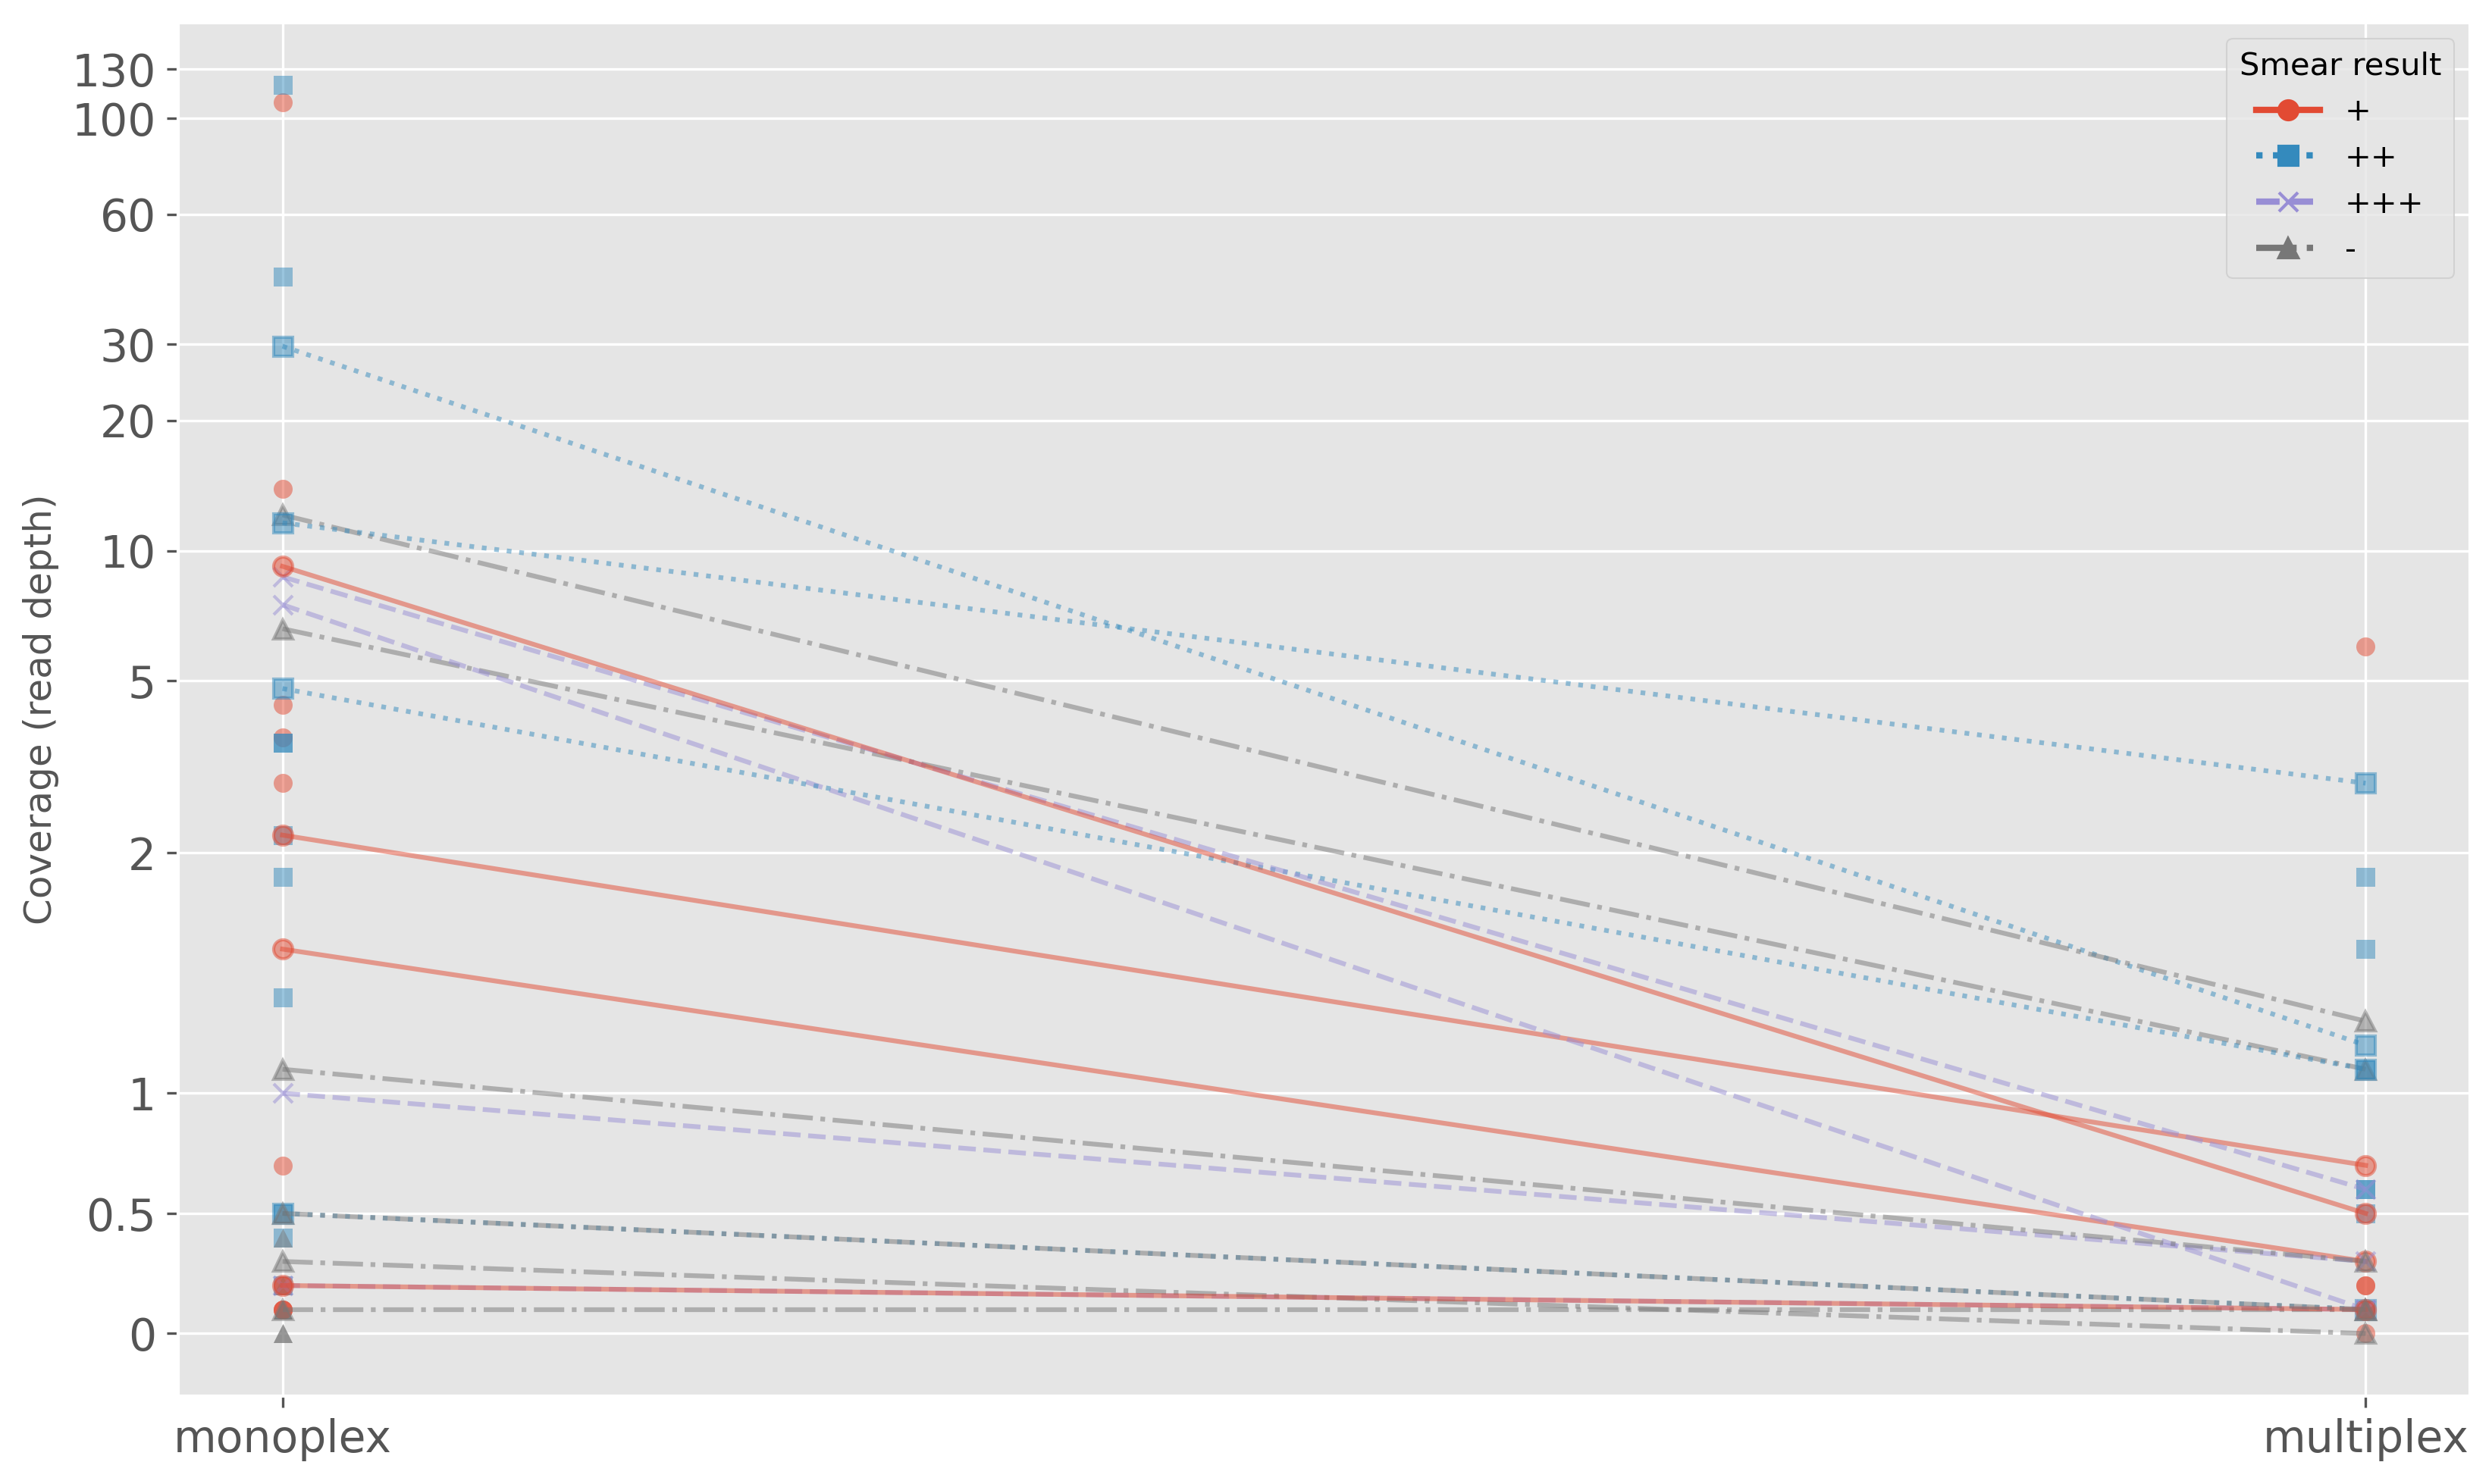

In [88]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)

ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
xs = []
ys = []
xs = {"monoplex": 0, "multiplex": 1}
x = "multiplexed"
y = "coverage"
smears = ["+", "++", "+++", "-"]
markers = ["o", "s", "x", "^"]
styles = ["-", ":", "--", "-."]
alpha = 0.5

single_only = singles - both
multi_only = multis - both

for _, row in data.query("name not in @both").iterrows():
    i = smears.index(row["smear"])
    colour = ggplot_cm[i]
    style = styles[i]
    marker = markers[i]
    ax.scatter(row[x], row[y], color=colour, alpha=alpha, marker=marker, lw=0)
    ax.set_yscale("symlog")
    ticks = [0, 0.5, 1, 2, 5, 10, 20, 30, 60, 100, 130]
    ax.set_yticks(ticks)
    _ = ax.set_yticklabels(ticks)  
# #     ax.set_ylim((-0.1, 140))

both_df = data.query("name in @both")
for i in range(0, len(both_df), 2):
    ix = smears.index(this_row["smear"])
    this_row = both_df.iloc[i]
    next_row = both_df.iloc[i+1]

    assert this_row["name"] == next_row["name"]
    colour = ggplot_cm[ix]
    style = styles[ix]
    marker = markers[ix]
    
    ax.plot([this_row[x], next_row[x]], [this_row[y], next_row[y]], color=colour, alpha=alpha, linestyle=style, marker=marker)






patches = [mlines.Line2D([], [], color=ggplot_cm[i], marker=markers[i], lw=2, ls=styles[i], label=s) for i, s in enumerate(smears)]
ax.set_xticks([0, 1])
ax.set_xticklabels(["monoplex", "multiplex"])
ax.set_ylabel("Coverage (read depth)")
plt.legend(handles=patches, title="Smear result")
for label in (ax.get_xticklabels() + ax.get_xticklabels()):
    label.set_fontsize(lsize)
ax.yaxis.set_tick_params(labelsize=lsize)

Summary tables

In [24]:
is_multiplex = ["multi" in s for s in comp_df["sample"]]
comp_df["is_multiplex"] = is_multiplex

In [89]:
comp_df.query("source=='sputum'").groupby(["smear", "technology", "is_multiplex"])["coverage"].describe()[["count", "50%", "min", "max"]]

count    50%  min    max
smear technology is_multiplex                          
+     illumina   False          20.0   0.90  0.1    7.1
      nanopore   False          14.0   2.55  0.1  108.8
                 True           10.0   0.25  0.0    6.0
++    illumina   False          20.0   2.30  0.1   12.0
      nanopore   False          14.0   2.05  0.2  119.3
                 True           10.0   0.85  0.1    2.9
+++   illumina   False          19.0   2.80  0.2  100.0
      nanopore   False          14.0  14.60  0.3   59.2
                 True           10.0   0.70  0.0   11.7
-     illumina   False          12.0   0.50  0.0    1.9
      nanopore   False          12.0   0.20  0.0    1.1
                 True            6.0   0.10  0.0    0.3

In [99]:
ont_df

,run,barcode,barcode_kit
sample,,,
P201,P201-P205,NB01,EXP-NBD104
P202,P201-P205,NB02,EXP-NBD104
P203-multiplex,P201-P205,NB03,EXP-NBD104
P203-singleplex,P203,NaN,NaN
P204,P201-P205,NB04,EXP-NBD104
...,...,...,...
Test_NC3-singleplex,Test_NC3,NaN,NaN
Test_NC3-multiplex,Multi_1Plus_sputum,NB06,EXP-NBD104
Test_NC4,Test_NC4,NaN,NaN


In [100]:
nanoq_tsvs = Path("../../results/nanopore/summary/").rglob("*.tsv")
dfs = []
for p in nanoq_tsvs:
    sample = p.name.split(".")[0]
    is_multi = not pd.isna(ont_df.at[sample, "barcode_kit"])
    name = sample_name(sample)
    frame = pd.read_csv(p, sep=" ")
    frame["sample"] = sample
    frame["is_multiplex"] = is_multi
    smears = list(set(comp_df.query("sample==@name")["smear"]))
    assert len(smears) == 1, p
    frame["smear"] = smears[0]
    frame["technology"] = "nanopore"
    dfs.append(frame)
nanoq_df = pd.concat(dfs)
nanoq_df

,reads,bases,n50,longest,shortest,mean_length,median_length,mean_quality,median_quality,sample,is_multiplex,smear,technology
0,8327,9531509,1805,9449,110,1144,767,13.2,13.0,P219,False,++,nanopore
0,7710,21012223,3938,14115,179,2725,2322,14.3,14.4,Test_36-singleplex,False,+++,nanopore
0,2376,7025375,4538,14220,81,2956,2526,15.2,15.5,Test_48,True,++,nanopore
0,269,665875,4028,9436,213,2475,1877,13.7,13.9,Test_32,False,+,nanopore
0,67,106093,3442,7960,166,1583,583,13.4,13.3,PCtrl-4,False,-,nanopore
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3867,8149217,3485,18620,86,2107,1635,15.3,15.4,Test_40,True,++,nanopore
0,114,204774,2662,5366,119,1796,1592,13.1,12.7,PCtrl-1-multiplex,True,-,nanopore
0,199920,261246021,1780,12685,112,1306,1104,13.9,13.9,P230,False,+++,nanopore
0,3801,4182133,1704,6962,53,1100,776,14.3,14.3,P224,True,+++,nanopore


In [101]:
data = comp_df
for smear in ["+", "++", "+++"]:
    print(smear)
    for tech in ["illumina", "nanopore"]:
        print(tech)
        for is_multi in [False, True]:
            for y in [1, 5, 20]:
                qry = "technology==@tech and smear==@smear and is_multiplex==@is_multi"
                d_total = data.query(qry)
                if d_total.empty:
                    continue
                else:
                    print(is_multi)
                d = d_total.query("coverage>=@y")
                p = len(d) / len(d_total)
                print(f"{p:.1%} ({len(d)}/{len(d_total)}) samples have coverage >= {y}")

+
illumina
False
72.2% (26/36) samples have coverage >= 1
False
50.0% (18/36) samples have coverage >= 5
False
44.4% (16/36) samples have coverage >= 20
nanopore
False
64.3% (9/14) samples have coverage >= 1
False
28.6% (4/14) samples have coverage >= 5
False
7.1% (1/14) samples have coverage >= 20
True
20.0% (2/10) samples have coverage >= 1
True
10.0% (1/10) samples have coverage >= 5
True
0.0% (0/10) samples have coverage >= 20
++
illumina
False
89.2% (33/37) samples have coverage >= 1
False
59.5% (22/37) samples have coverage >= 5
False
45.9% (17/37) samples have coverage >= 20
nanopore
False
71.4% (10/14) samples have coverage >= 1
False
28.6% (4/14) samples have coverage >= 5
False
14.3% (2/14) samples have coverage >= 20
True
50.0% (5/10) samples have coverage >= 1
True
0.0% (0/10) samples have coverage >= 5
True
0.0% (0/10) samples have coverage >= 20
+++
illumina
False
89.5% (34/38) samples have coverage >= 1
False
60.5% (23/38) samples have coverage >= 5
False
55.3% (21/38) s

In [102]:
illumina_read_length = 150

Remove culture isolates, negative smear, and replicates

In [103]:
summary = comp_df.query("source=='sputum' and smear!='-'")

In [104]:
summary = summary.loc[~summary["sample"].str.contains("_rep")]

In [112]:
summary.set_index(["sample", "technology", "is_multiplex"], inplace=True, verify_integrity=True)

KeyError: "None of ['sample', 'technology', 'is_multiplex'] are in the columns"

In [113]:
nanoq_df

,reads,bases,n50,longest,shortest,mean_length,median_length,mean_quality,median_quality,sample,is_multiplex,smear,technology
0,8327,9531509,1805,9449,110,1144,767,13.2,13.0,P219,False,++,nanopore
0,7710,21012223,3938,14115,179,2725,2322,14.3,14.4,Test_36-singleplex,False,+++,nanopore
0,2376,7025375,4538,14220,81,2956,2526,15.2,15.5,Test_48,True,++,nanopore
0,269,665875,4028,9436,213,2475,1877,13.7,13.9,Test_32,False,+,nanopore
0,67,106093,3442,7960,166,1583,583,13.4,13.3,PCtrl-4,False,-,nanopore
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3867,8149217,3485,18620,86,2107,1635,15.3,15.4,Test_40,True,++,nanopore
0,114,204774,2662,5366,119,1796,1592,13.1,12.7,PCtrl-1-multiplex,True,-,nanopore
0,199920,261246021,1780,12685,112,1306,1104,13.9,13.9,P230,False,+++,nanopore
0,3801,4182133,1704,6962,53,1100,776,14.3,14.3,P224,True,+++,nanopore


Add read length

In [114]:
for i, row in nanoq_df.iterrows():
    sample = row["sample"]
    is_multi = row["is_multiplex"]
    if summary.query("sample==@sample").empty:
        continue
    try:
        summary.at[(sample, "nanopore", is_multi), "length"] = row["median_length"]
    except KeyError:
        continue

In [115]:
summary.fillna(illumina_read_length, inplace=True)

In [116]:
summary

index   keep  keep%   contam contam%  \
sample  technology is_multiplex                                         
P201    nanopore   True              0    895  0.11%   644877  77.08%   
P202    nanopore   True              1  24865  1.83%  1153816  85.11%   
P203    nanopore   True              2   3768  0.46%   783301  95.23%   
                   False             3  19938  0.45%  4257677  96.47%   
P204    nanopore   True              4    414  0.07%    57693  10.05%   
...                                ...    ...    ...      ...     ...   
Test_54 illumina   False            79   5851  0.34%  1619653  95.29%   
Test_55 illumina   False            80   2333  2.77%    76258  90.39%   
Test_56 illumina   False            81  35856  0.94%  3620359  95.19%   
Test_60 illumina   False            82  14546  0.42%  3432638  99.22%   
Test_65 illumina   False            83  42764  1.46%  2874961  98.44%   

                                 unmapped unmapped%    total  coverage  \
sample  technology is_multiplex                                          
P201    nanopore   True            190847    22.81%   836619       0.2   
P202    nanopore   True            176981    13.05%  1355662       6.0   
P203    nanopore   True             35497     4.32%   822566       1.1   
                   False           136039     3.08%  4413654       6.6   
P204    nanopore   True            515903    89.88%   574010       0.1   
...                                   ...       ...      ...       ...   
Test_54 illumina   False            74276     4.37%  1699780       0.4   
Test_55 illumina   False             5775     6.85%    84366       0.1   
Test_56 illumina   False           147247     3.87%  3803462       2.4   
Test_60 illumina   False            12271     0.35%  3459455       1.0   
Test_65 illumina   False             2820     0.10%  2920545       2.9   

                                           lineage  \
sample  technology is_multiplex                      
P201    nanopore   True                       4.10   
P202    nanopore   True                      1.1.2   
P203    nanopore   True                       4.10   
                   False                     4.1.2   
P204    nanopore   True                       4.10   
...                                            ...   
Test_54 illumina   False                      4.10   
Test_55 illumina   False                      4.10   
Test_56 illumina   False                       2.2   
Test_60 illumina   False         Beijing_East_Asia   
Test_65 illumina   False                         4   

                                                    species  source smear  \
sample  technology is_multiplex                                             
P201    nanopore   True          Mycobacterium_tuberculosis  sputum     +   
P202    nanopore   True          Mycobacterium_tuberculosis  sputum     +   
P203    nanopore   True          Mycobacterium_tuberculosis  sputum     +   
                   False         Mycobacterium_tuberculosis  sputum     +   
P204    nanopore   True                             Unknown  sputum     +   
...                                                     ...     ...   ...   
Test_54 illumina   False         Mycobacterium_tuberculosis  sputum     +   
Test_55 illumina   False         Mycobacterium_tuberculosis  sputum    ++   
Test_56 illumina   False         Mycobacterium_tuberculosis  sputum   +++   
Test_60 illumina   False         Mycobacterium_tuberculosis  sputum     +   
Test_65 illumina   False         Mycobacterium_tuberculosis  sputum   +++   

                                 length  
sample  technology is_multiplex          
P201    nanopore   True           947.0  
P202    nanopore   True           853.0  
P203    nanopore   True           150.0  
                   False          150.0  
P204    nanopore   True          1313.0  
...                                 ...  
Test_54 illumina   False          150.0  
Test_55 illumina   False          150

Write pandas table to Word document: https://stackoverflow.com/a/40597684/5299417

In [117]:
import docx
from itertools import product

In [127]:
smears = ["+", "++", "+++"]
tech = ["illumina", "nanopore"]
multi = [False, True]
rows = defaultdict(str)
delim = "\t"
headers = [delim, delim]
combinations = [("illumina", "+", False), 
                ("illumina", "++", False), 
                ("illumina", "+++", False), 
                ("nanopore", "+", False), 
                ("nanopore", "++", False), 
                ("nanopore", "+++", False), 
                ("nanopore", "+", True), 
                ("nanopore", "++", True), 
                ("nanopore", "+++", True)]
for t, s, m in combinations:
    if (t, m) == ("illumina", True):
        continue
    tech_df = summary.query("technology==@t and is_multiplex==@m")
    if s == '+':
        headers[0] += f"{t.capitalize()} (n={len(tech_df)}){delim*3}"
    smear_df = tech_df.query("smear==@s")
    headers[1] += f"{s.count('+')}+ (n={len(smear_df)}){delim}"
    # total sequenced reads
    totals = smear_df["total"]
    rows["Total reads [median (range)]"] += f"{delim}{int(totals.median()):,d} ({int(totals.min()):,d}-{int(totals.max()):,d})"
    # read length
    if t == "illumina":
        rows["Read length [median (range)]"] += f"{delim}{illumina_read_length}"
    else:
        subdf = nanoq_df.query("is_multiplex==@m and smear==@s")
        lens = nanoq_df["median_length"]
        rows["Read length [median (range)]"] += f"{delim}{int(lens.median()):,d} ({int(lens.min()):,d}-{int(lens.max()):,d})"
    # contamination reads
    contam = smear_df["contam"]
    rows["Contamination reads [median (range)]"] += f"{delim}{int(contam.median()):,d} ({int(contam.min()):,d}-{int(contam.max()):,d})"
    # mtbc reads
    keep = smear_df["keep"]
    rows["MTB reads [median (range)]"] += f"{delim}{int(keep.median()):,d} ({int(keep.min()):,d}-{int(keep.max()):,d})"
    # average depth
    covg = smear_df["coverage"]
    rows["Coverage [median (range)]"] += f"{delim}{round(covg.median(), 1)} ({covg.min()}-{covg.max()})"
    
for y in [1, 5, 20]:
    for t, s, m in combinations:
        tech_df = summary.query("technology==@t and is_multiplex==@m")
        smear_df = tech_df.query("smear==@s")
        if (t, m) == ("illumina", True):
            continue

        covdf = smear_df.query("coverage>=@y")
        p = len(covdf) / len(smear_df)
        rows[f">={y}X coverage"] += f"{delim}{len(covdf)} ({p:.0%})"

In [119]:
for k in rows:
    print(k)

Total reads [median (range)]
Read length [median (range)]
Contamination reads [median (range)]
MTB reads [median (range)]
Coverage [median (range)]
>=1X coverage
>=5X coverage
>=20X coverage


In [128]:
with open("composition_summary.tsv", "w") as fp:
    for l in headers:
        print(l, file=fp)
    for k, row in rows.items():
        print(f"{k}{row}", file=fp)

In [84]:
for s in comp_df["sample"]:
    print(s)

P201
P202
P203-multiplex
P203-singleplex
P204
P205-multiplex
P205-singleplex
P206
P207
P208
P209
P210
P211-multiplex
P211-singleplex
P212
P213-multiplex
P213-singleplex
P214
P215
P216
P217
P218
P219
P220
P221
P222-multiplex
P222-singleplex
P223
P224
P225-multiplex
P225-singleplex
P226
P227
P228
P229
P230
PCtrl-1-multiplex
PCtrl-1-singleplex
PCtrl-2
PCtrl-3-multiplex
PCtrl-3-singleplex
PCtrl-4
PCtrl-5-multiplex
PCtrl-5-singleplex
PCtrl-6
Test_15-multiplex
Test_15-singleplex
Test_16
Test_18
Test_19
Test_20
Test_22
Test_23
Test_28-multiplex
Test_28-singleplex
Test_32
Test_34
Test_36-multiplex
Test_36-singleplex
Test_37
Test_38
Test_40
Test_41
Test_42-multiplex
Test_42-singleplex
Test_43-multiplex
Test_43-singleplex
Test_45
Test_46
Test_47
Test_48
Test_50
Test_51
Test_52
Test_53
Test_54-multiplex
Test_54-singleplex
Test_55
Test_56
Test_60
Test_65
Test_NC1-multiplex
Test_NC1-singleplex
Test_NC2-multiplex
Test_NC2-singleplex
Test_NC3-multiplex
Test_NC3-singleplex
Test_NC4
Test_NC5
Test_NC6
P

In [126]:
f"{int(keep.median()):,d}"

'1,814'